In [1]:
import random
import sys
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics.cluster import adjusted_rand_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scripts.data_generator as data_generator
import scripts.feature_ranking as feature_ranking
import scripts.features_2d as features_2d
import scripts.ga as ga
import scripts.preprocess as preprocess
import scripts.ga_evaluation as ga_evaluation
import scripts.bio_analysis as bio_analysis
from sklearn import preprocessing
import tensorflow as tf
from IPython import get_ipython
from keras.backend.tensorflow_backend import set_session
from tqdm import tqdm
from collections import Counter
import h5py
config = tf.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
sess = tf.Session(config=config)
set_session(sess)  # set this TensorFlow session as the default

plt.ion()
plt.show()
sys.path.append("..")

random_state=0
random.seed( random_state )
np.random.seed(random_state)

from warnings import filterwarnings
filterwarnings('ignore')

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)
Using TensorFlow backend.


Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce RTX 2060, pci bus id: 0000:01:00.0, compute capability: 7.5



In [2]:
%load_ext autoreload
%autoreload 2

# Start here if preprocessing files have been generated

In [4]:
filename = 'mouse_ES_cell'

data_mat = h5py.File(f"data/scRNAseq/{filename}.h5")


In [5]:
data = np.array(data_mat['X'])
truth = np.array(data_mat['Y']) -1
n_clusters = len(np.unique(truth))
Counter(truth), data.shape

(Counter({0.0: 933, 1.0: 303, 2.0: 683, 3.0: 798}), (2717, 24175))

keepUnique 8618
keepZeros 6893


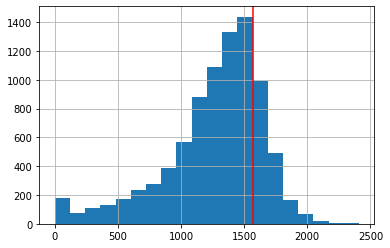

In [6]:
unq = np.array([len(np.unique(data[:, x])) for x in range(data.shape[1])])
keepUnique = np.where(unq > n_clusters* 2)[0]
print(f"keepUnique {len(keepUnique)}")
data = data[:, keepUnique]
data.shape

data = pd.DataFrame(data)

data = data[data ==0]

data = data.replace(0, 1)

data = data.fillna(0)

zeros = data.sum(axis = 0)


threshold = np.percentile(zeros.values, 80)

keepZeros = np.where(zeros.values < threshold)[0]
print(f"keepZeros {len(keepZeros)}")
zeros.hist(bins = 20)
plt.axvline(threshold , c = "red")

In [7]:
data = np.array(data_mat['X'])

data = data[:, keepUnique]
data = data[:, keepZeros]

data = preprocessing.MinMaxScaler().fit_transform(data)
data.shape

(2717, 6893)

In [8]:
meta_features = feature_ranking.rank_features(data,
                                              nb_bins=20,
                                              rank_threshold=85,
                                              z_file=None,
                                              metric='correlation',
                                              redundant_threshold=0.4)

*** Computing 1D feature ranking ...
Dispersion tests took 8.38 sec
Entropy computation 29.88 sec
KNN computation 116.88 sec
Sorting and thresholds 0.04 sec
Performing hierarchical clustering...
Hierarchical clustering 64.89 sec
Handle redundant features 0.94 sec
Returning 552 redundant features and  697 important features


In [9]:
model_file = "models/gmm_arl.h5"
gmm_arl_population, n = features_2d.run(data,
                                n_clusters,
                                meta_features,
                                model_file=model_file,
                                theta=0.1,
                                add_close_population=True,
                                exploration_factor = 5)
print(gmm_arl_population.shape, n)

*** Exploring 2D feature space with NN ...
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


handle_close_important (1920, 3), total 8520, 0.15164771676063538
relevant_features 2564 => computing 25539 
trimming 1056 to 552
handle_important_features (2472, 3),  total 25964, 0.15164771676063538
irrelevant_features 3777 => computing 18852
trimming 4318 to 3170
handle_not_important_features (5642, 3), total 19321, 0.15164771676063538
handle_all_features 6341 => computing 31672
handle_all_features (9638, 3),  total 32168, 0.15164771676063538
Returning (9559, 3), explored a total of 85973 feature pairs
(9559, 4) 85973


In [10]:
globalResults = {}

In [11]:
method = "adapted_ratkowsky_lance"
threshold=0.09#
score_tolerance=0.009
clustering = "gmm"

round_size = 4
debug = False
ignore_redundant= True
epochs = 10*round_size
pca = False
sampling = {
    "ARCHIVE2D": { 
        "ga": 0.4,
        "max": 0.4 },
    "CLOSE": { 
        "ga": 0.3,
        "max": 0.3 },
    "IMP1D": { 
        "ga": 0.2,
        "max": 0.2 },
    "RANDOM": { 
        "ga": 0.1,
        "max": 0.1},
}
params = ga.ga_parameters(
    n_clusters,
    data.shape[1],
    truth,
    meta_features,
    method=method,
    truth_methods=['ari'],
    archive_2d=gmm_arl_population[gmm_arl_population["pred"] > threshold].iloc[:3000],
    debug=debug,
    epochs=epochs,
    round_size=round_size,
    sampling = sampling,
    ignore_redundant = ignore_redundant,
    allow_subspace_overlap = False,
    improvement_per_mutation_report = True,
    score_tolerance=score_tolerance,
    clustering = clustering,
    total_maximisation_exploration = 300,
    max_subspace_size = 80,
    maximisation_size = 100,
    pca = pca

)
print(params["sampling_actions"], params["maximisation_sizes"] , params["sampling_prob"])
params

solutions, archive= ga.run(data, params)
display(solutions)
globalResults[f"{clustering}_{method}_{pca}"] = solutions

  0%|          | 0/41 [00:00<?, ?it/s]

*** Optimization algorithm 
Non redundant features 6341, orig size 6893, nb imp : 697
['ARCHIVE2D', 'CLOSE', 'IMP1D', 'RANDOM'] [40 30 20 10] [0.4, 0.3, 0.2, 0.1]
Selecting (50, 4) from archive


 10%|▉         | 4/41 [01:21<12:43, 20.62s/it]

,adapted_ratkowsky_lance,ari,features,partition,size,structure
0,0.128251,0.04,"[1967, 1968, 5086, 5133]","[2, 2, 2, 3, 1, 2, 2, 2, 1, 1, 1, 1, 2, 1, 0, ...",4.0,"Counter({3: 1018, 1: 870, 2: 653, 0: 176})"


Selecting (2, 4) from archive


 20%|█▉        | 8/41 [03:47<15:14, 27.72s/it]

,adapted_ratkowsky_lance,ari,features,partition,size,structure
0,0.128251,0.04,"[1967, 1968, 5086, 5133]","[2, 2, 2, 3, 1, 2, 2, 2, 1, 1, 1, 1, 2, 1, 0, ...",4.0,"Counter({3: 1018, 1: 870, 2: 653, 0: 176})"
1,0.122739,0.71,"[69, 114, 126, 139, 152, 166, 216, 277, 300, 3...","[2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, ...",81.0,"Counter({3: 958, 2: 931, 1: 495, 0: 333})"


Selecting (21, 4) from archive


 29%|██▉       | 12/41 [18:06<52:03, 107.70s/it]  

,adapted_ratkowsky_lance,ari,features,partition,size,structure
0,0.128251,0.04,"[1967, 1968, 5086, 5133]","[2, 2, 2, 3, 1, 2, 2, 2, 1, 1, 1, 1, 2, 1, 0, ...",4.0,"Counter({3: 1018, 1: 870, 2: 653, 0: 176})"
1,0.122739,0.71,"[69, 114, 126, 139, 152, 166, 216, 277, 300, 3...","[2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, ...",81.0,"Counter({3: 958, 2: 931, 1: 495, 0: 333})"
2,0.134090,0.31,"[17, 194, 379, 433, 466, 623, 708, 755, 867, 1...","[3, 3, 3, 0, 2, 3, 0, 3, 2, 2, 2, 2, 0, 2, 3, ...",117.0,"Counter({2: 926, 1: 915, 0: 599, 3: 277})"


Selecting (37, 4) from archive


 39%|███▉      | 16/41 [25:20<32:43, 78.53s/it]   

,adapted_ratkowsky_lance,ari,features,partition,size,structure
0,0.128251,0.04,"[1967, 1968, 5086, 5133]","[2, 2, 2, 3, 1, 2, 2, 2, 1, 1, 1, 1, 2, 1, 0, ...",4.0,"Counter({3: 1018, 1: 870, 2: 653, 0: 176})"
1,0.122739,0.71,"[69, 114, 126, 139, 152, 166, 216, 277, 300, 3...","[2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, ...",81.0,"Counter({3: 958, 2: 931, 1: 495, 0: 333})"
2,0.134090,0.31,"[17, 194, 379, 433, 466, 623, 708, 755, 867, 1...","[3, 3, 3, 0, 2, 3, 0, 3, 2, 2, 2, 2, 0, 2, 3, ...",117.0,"Counter({2: 926, 1: 915, 0: 599, 3: 277})"
3,0.117264,0.39,"[328, 559, 789, 871, 962, 1132, 1186, 1251, 13...","[2, 2, 0, 3, 3, 2, 3, 0, 3, 3, 3, 3, 3, 3, 2, ...",96.0,"Counter({1: 999, 3: 893, 2: 602, 0: 223})"


Selecting (39, 4) from archive


 49%|████▉     | 20/41 [32:36<24:20, 69.56s/it]   

,adapted_ratkowsky_lance,ari,features,partition,size,structure
0,0.128251,0.04,"[1967, 1968, 5086, 5133]","[2, 2, 2, 3, 1, 2, 2, 2, 1, 1, 1, 1, 2, 1, 0, ...",4.0,"Counter({3: 1018, 1: 870, 2: 653, 0: 176})"
1,0.122739,0.71,"[69, 114, 126, 139, 152, 166, 216, 277, 300, 3...","[2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, ...",81.0,"Counter({3: 958, 2: 931, 1: 495, 0: 333})"
2,0.134090,0.31,"[17, 194, 379, 433, 466, 623, 708, 755, 867, 1...","[3, 3, 3, 0, 2, 3, 0, 3, 2, 2, 2, 2, 0, 2, 3, ...",117.0,"Counter({2: 926, 1: 915, 0: 599, 3: 277})"
3,0.117264,0.39,"[328, 559, 789, 871, 962, 1132, 1186, 1251, 13...","[2, 2, 0, 3, 3, 2, 3, 0, 3, 3, 3, 3, 3, 3, 2, ...",96.0,"Counter({1: 999, 3: 893, 2: 602, 0: 223})"
4,0.125946,0.24,"[439, 440, 923]","[1, 2, 0, 1, 1, 2, 1, 2, 1, 1, 0, 1, 1, 0, 0, ...",3.0,"Counter({1: 1014, 3: 896, 2: 554, 0: 253})"


Selecting (2, 4) from archive


 59%|█████▊    | 24/41 [34:10<09:13, 32.58s/it]

,adapted_ratkowsky_lance,ari,features,partition,size,structure
0,0.128251,0.04,"[1967, 1968, 5086, 5133]","[2, 2, 2, 3, 1, 2, 2, 2, 1, 1, 1, 1, 2, 1, 0, ...",4.0,"Counter({3: 1018, 1: 870, 2: 653, 0: 176})"
1,0.122739,0.71,"[69, 114, 126, 139, 152, 166, 216, 277, 300, 3...","[2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, ...",81.0,"Counter({3: 958, 2: 931, 1: 495, 0: 333})"
2,0.134090,0.31,"[17, 194, 379, 433, 466, 623, 708, 755, 867, 1...","[3, 3, 3, 0, 2, 3, 0, 3, 2, 2, 2, 2, 0, 2, 3, ...",117.0,"Counter({2: 926, 1: 915, 0: 599, 3: 277})"
3,0.117264,0.39,"[328, 559, 789, 871, 962, 1132, 1186, 1251, 13...","[2, 2, 0, 3, 3, 2, 3, 0, 3, 3, 3, 3, 3, 3, 2, ...",96.0,"Counter({1: 999, 3: 893, 2: 602, 0: 223})"
4,0.125946,0.24,"[439, 440, 923]","[1, 2, 0, 1, 1, 2, 1, 2, 1, 1, 0, 1, 1, 0, 0, ...",3.0,"Counter({1: 1014, 3: 896, 2: 554, 0: 253})"
5,0.117290,0.33,"[63, 107, 158, 183, 234, 241, 246, 250, 381, 6...","[2, 0, 0, 2, 3, 0, 2, 0, 3, 3, 3, 3, 3, 3, 0, ...",112.0,"Counter({1: 1019, 3: 847, 2: 587, 0: 264})"


Selecting (20, 4) from archive


 68%|██████▊   | 28/41 [43:18<15:17, 70.59s/it] 

,adapted_ratkowsky_lance,ari,features,partition,size,structure
0,0.128251,0.04,"[1967, 1968, 5086, 5133]","[2, 2, 2, 3, 1, 2, 2, 2, 1, 1, 1, 1, 2, 1, 0, ...",4.0,"Counter({3: 1018, 1: 870, 2: 653, 0: 176})"
1,0.122739,0.71,"[69, 114, 126, 139, 152, 166, 216, 277, 300, 3...","[2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, ...",81.0,"Counter({3: 958, 2: 931, 1: 495, 0: 333})"
2,0.134090,0.31,"[17, 194, 379, 433, 466, 623, 708, 755, 867, 1...","[3, 3, 3, 0, 2, 3, 0, 3, 2, 2, 2, 2, 0, 2, 3, ...",117.0,"Counter({2: 926, 1: 915, 0: 599, 3: 277})"
3,0.117264,0.39,"[328, 559, 789, 871, 962, 1132, 1186, 1251, 13...","[2, 2, 0, 3, 3, 2, 3, 0, 3, 3, 3, 3, 3, 3, 2, ...",96.0,"Counter({1: 999, 3: 893, 2: 602, 0: 223})"
4,0.125946,0.24,"[439, 440, 923]","[1, 2, 0, 1, 1, 2, 1, 2, 1, 1, 0, 1, 1, 0, 0, ...",3.0,"Counter({1: 1014, 3: 896, 2: 554, 0: 253})"
5,0.117290,0.33,"[63, 107, 158, 183, 234, 241, 246, 250, 381, 6...","[2, 0, 0, 2, 3, 0, 2, 0, 3, 3, 3, 3, 3, 3, 0, ...",112.0,"Counter({1: 1019, 3: 847, 2: 587, 0: 264})"
6,0.117943,0.29,"[160, 481, 3748, 6499]","[2, 3, 2, 3, 3, 2, 3, 2, 3, 1, 3, 1, 0, 3, 3, ...",4.0,"Counter({1: 1052, 3: 926, 2: 377, 0: 362})"


Selecting (5, 4) from archive


 78%|███████▊  | 32/41 [44:43<04:38, 30.92s/it]

,adapted_ratkowsky_lance,ari,features,partition,size,structure
0,0.128251,0.04,"[1967, 1968, 5086, 5133]","[2, 2, 2, 3, 1, 2, 2, 2, 1, 1, 1, 1, 2, 1, 0, ...",4.0,"Counter({3: 1018, 1: 870, 2: 653, 0: 176})"
1,0.122739,0.71,"[69, 114, 126, 139, 152, 166, 216, 277, 300, 3...","[2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, ...",81.0,"Counter({3: 958, 2: 931, 1: 495, 0: 333})"
2,0.134090,0.31,"[17, 194, 379, 433, 466, 623, 708, 755, 867, 1...","[3, 3, 3, 0, 2, 3, 0, 3, 2, 2, 2, 2, 0, 2, 3, ...",117.0,"Counter({2: 926, 1: 915, 0: 599, 3: 277})"
3,0.117264,0.39,"[328, 559, 789, 871, 962, 1132, 1186, 1251, 13...","[2, 2, 0, 3, 3, 2, 3, 0, 3, 3, 3, 3, 3, 3, 2, ...",96.0,"Counter({1: 999, 3: 893, 2: 602, 0: 223})"
4,0.125946,0.24,"[439, 440, 923]","[1, 2, 0, 1, 1, 2, 1, 2, 1, 1, 0, 1, 1, 0, 0, ...",3.0,"Counter({1: 1014, 3: 896, 2: 554, 0: 253})"
5,0.117290,0.33,"[63, 107, 158, 183, 234, 241, 246, 250, 381, 6...","[2, 0, 0, 2, 3, 0, 2, 0, 3, 3, 3, 3, 3, 3, 0, ...",112.0,"Counter({1: 1019, 3: 847, 2: 587, 0: 264})"
6,0.117943,0.29,"[160, 481, 3748, 6499]","[2, 3, 2, 3, 3, 2, 3, 2, 3, 1, 3, 1, 0, 3, 3, ...",4.0,"Counter({1: 1052, 3: 926, 2: 377, 0: 362})"
7,0.116951,0.35,"[99, 523, 633, 634, 676, 947, 975, 1147, 1299,...","[2, 0, 0, 2, 3, 0, 2, 0, 2, 3, 2, 3, 2, 2, 0, ...",43.0,"Counter({1: 941, 2: 905, 3: 610, 0: 261})"


Selecting (20, 4) from archive


 88%|████████▊ | 36/41 [54:31<06:25, 77.00s/it] 

,adapted_ratkowsky_lance,ari,features,partition,size,structure
0,0.128251,0.04,"[1967, 1968, 5086, 5133]","[2, 2, 2, 3, 1, 2, 2, 2, 1, 1, 1, 1, 2, 1, 0, ...",4.0,"Counter({3: 1018, 1: 870, 2: 653, 0: 176})"
1,0.122739,0.71,"[69, 114, 126, 139, 152, 166, 216, 277, 300, 3...","[2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, ...",81.0,"Counter({3: 958, 2: 931, 1: 495, 0: 333})"
2,0.134090,0.31,"[17, 194, 379, 433, 466, 623, 708, 755, 867, 1...","[3, 3, 3, 0, 2, 3, 0, 3, 2, 2, 2, 2, 0, 2, 3, ...",117.0,"Counter({2: 926, 1: 915, 0: 599, 3: 277})"
3,0.117264,0.39,"[328, 559, 789, 871, 962, 1132, 1186, 1251, 13...","[2, 2, 0, 3, 3, 2, 3, 0, 3, 3, 3, 3, 3, 3, 2, ...",96.0,"Counter({1: 999, 3: 893, 2: 602, 0: 223})"
4,0.125946,0.24,"[439, 440, 923]","[1, 2, 0, 1, 1, 2, 1, 2, 1, 1, 0, 1, 1, 0, 0, ...",3.0,"Counter({1: 1014, 3: 896, 2: 554, 0: 253})"
5,0.117290,0.33,"[63, 107, 158, 183, 234, 241, 246, 250, 381, 6...","[2, 0, 0, 2, 3, 0, 2, 0, 3, 3, 3, 3, 3, 3, 0, ...",112.0,"Counter({1: 1019, 3: 847, 2: 587, 0: 264})"
6,0.117943,0.29,"[160, 481, 3748, 6499]","[2, 3, 2, 3, 3, 2, 3, 2, 3, 1, 3, 1, 0, 3, 3, ...",4.0,"Counter({1: 1052, 3: 926, 2: 377, 0: 362})"
7,0.116951,0.35,"[99, 523, 633, 634, 676, 947, 975, 1147, 1299,...","[2, 0, 0, 2, 3, 0, 2, 0, 2, 3, 2, 3, 2, 2, 0, ...",43.0,"Counter({1: 941, 2: 905, 3: 610, 0: 261})"
8,0.114134,0.38,"[137, 220, 483, 488, 627, 654, 668, 914, 1044,...","[3, 3, 0, 2, 2, 3, 3, 0, 2, 2, 2, 2, 2, 2, 3, ...",103.0,"Counter({1: 988, 2: 907, 3: 635, 0: 187})"


Selecting (11, 4) from archive


 98%|█████████▊| 40/41 [1:01:07<01:03, 63.85s/it] 

,adapted_ratkowsky_lance,ari,features,partition,size,structure
0,0.128251,0.04,"[1967, 1968, 5086, 5133]","[2, 2, 2, 3, 1, 2, 2, 2, 1, 1, 1, 1, 2, 1, 0, ...",4.0,"Counter({3: 1018, 1: 870, 2: 653, 0: 176})"
1,0.122739,0.71,"[69, 114, 126, 139, 152, 166, 216, 277, 300, 3...","[2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, ...",81.0,"Counter({3: 958, 2: 931, 1: 495, 0: 333})"
2,0.134090,0.31,"[17, 194, 379, 433, 466, 623, 708, 755, 867, 1...","[3, 3, 3, 0, 2, 3, 0, 3, 2, 2, 2, 2, 0, 2, 3, ...",117.0,"Counter({2: 926, 1: 915, 0: 599, 3: 277})"
3,0.117264,0.39,"[328, 559, 789, 871, 962, 1132, 1186, 1251, 13...","[2, 2, 0, 3, 3, 2, 3, 0, 3, 3, 3, 3, 3, 3, 2, ...",96.0,"Counter({1: 999, 3: 893, 2: 602, 0: 223})"
4,0.125946,0.24,"[439, 440, 923]","[1, 2, 0, 1, 1, 2, 1, 2, 1, 1, 0, 1, 1, 0, 0, ...",3.0,"Counter({1: 1014, 3: 896, 2: 554, 0: 253})"
5,0.117290,0.33,"[63, 107, 158, 183, 234, 241, 246, 250, 381, 6...","[2, 0, 0, 2, 3, 0, 2, 0, 3, 3, 3, 3, 3, 3, 0, ...",112.0,"Counter({1: 1019, 3: 847, 2: 587, 0: 264})"
6,0.117943,0.29,"[160, 481, 3748, 6499]","[2, 3, 2, 3, 3, 2, 3, 2, 3, 1, 3, 1, 0, 3, 3, ...",4.0,"Counter({1: 1052, 3: 926, 2: 377, 0: 362})"
7,0.116951,0.35,"[99, 523, 633, 634, 676, 947, 975, 1147, 1299,...","[2, 0, 0, 2, 3, 0, 2, 0, 2, 3, 2, 3, 2, 2, 0, ...",43.0,"Counter({1: 941, 2: 905, 3: 610, 0: 261})"
8,0.114134,0.38,"[137, 220, 483, 488, 627, 654, 668, 914, 1044,...","[3, 3, 0, 2, 2, 3, 3, 0, 2, 2, 2, 2, 2, 2, 3, ...",103.0,"Counter({1: 988, 2: 907, 3: 635, 0: 187})"
9,0.114580,0.40,"[249, 468, 775, 1830, 2123, 2346, 2737, 2968, ...","[2, 2, 2, 2, 1, 2, 2, 0, 1, 1, 2, 1, 2, 2, 2, ...",20.0,"Counter({2: 978, 3: 887, 1: 482, 0: 370})"


Selecting (7, 4) from archive


100%|██████████| 41/41 [1:04:33<00:00, 94.48s/it] 


,adapted_ratkowsky_lance,ari,features,partition,size,structure
0,0.128251,0.04,"[1967, 1968, 5086, 5133]","[2, 2, 2, 3, 1, 2, 2, 2, 1, 1, 1, 1, 2, 1, 0, ...",4.0,"Counter({3: 1018, 1: 870, 2: 653, 0: 176})"
1,0.122739,0.71,"[69, 114, 126, 139, 152, 166, 216, 277, 300, 3...","[2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, ...",81.0,"Counter({3: 958, 2: 931, 1: 495, 0: 333})"
2,0.134090,0.31,"[17, 194, 379, 433, 466, 623, 708, 755, 867, 1...","[3, 3, 3, 0, 2, 3, 0, 3, 2, 2, 2, 2, 0, 2, 3, ...",117.0,"Counter({2: 926, 1: 915, 0: 599, 3: 277})"
3,0.117264,0.39,"[328, 559, 789, 871, 962, 1132, 1186, 1251, 13...","[2, 2, 0, 3, 3, 2, 3, 0, 3, 3, 3, 3, 3, 3, 2, ...",96.0,"Counter({1: 999, 3: 893, 2: 602, 0: 223})"
4,0.125946,0.24,"[439, 440, 923]","[1, 2, 0, 1, 1, 2, 1, 2, 1, 1, 0, 1, 1, 0, 0, ...",3.0,"Counter({1: 1014, 3: 896, 2: 554, 0: 253})"
5,0.117290,0.33,"[63, 107, 158, 183, 234, 241, 246, 250, 381, 6...","[2, 0, 0, 2, 3, 0, 2, 0, 3, 3, 3, 3, 3, 3, 0, ...",112.0,"Counter({1: 1019, 3: 847, 2: 587, 0: 264})"
6,0.117943,0.29,"[160, 481, 3748, 6499]","[2, 3, 2, 3, 3, 2, 3, 2, 3, 1, 3, 1, 0, 3, 3, ...",4.0,"Counter({1: 1052, 3: 926, 2: 377, 0: 362})"
7,0.116951,0.35,"[99, 523, 633, 634, 676, 947, 975, 1147, 1299,...","[2, 0, 0, 2, 3, 0, 2, 0, 2, 3, 2, 3, 2, 2, 0, ...",43.0,"Counter({1: 941, 2: 905, 3: 610, 0: 261})"
8,0.114134,0.38,"[137, 220, 483, 488, 627, 654, 668, 914, 1044,...","[3, 3, 0, 2, 2, 3, 3, 0, 2, 2, 2, 2, 2, 2, 3, ...",103.0,"Counter({1: 988, 2: 907, 3: 635, 0: 187})"
9,0.114580,0.40,"[249, 468, 775, 1830, 2123, 2346, 2737, 2968, ...","[2, 2, 2, 2, 1, 2, 2, 0, 1, 1, 2, 1, 2, 2, 2, ...",20.0,"Counter({2: 978, 3: 887, 1: 482, 0: 370})"


In [12]:
method = "adapted_silhouette"
threshold=0.09#
score_tolerance=0.009
clustering = "hdbscan"

round_size = 3
debug = False
ignore_redundant= True
epochs = 10*round_size

sampling = {
    "ARCHIVE2D": { 
        "ga": 0.3,
        "max": 0.3 },
    "CLOSE": { 
        "ga": 0.4,
        "max": 0.4 },
    "IMP1D": { 
        "ga": 0.2,
        "max": 0.2 },
    "RANDOM": { 
        "ga": 0.1,
        "max": 0.1},
}
params = ga.ga_parameters(
    n_clusters,
    data.shape[1],
    truth,
    meta_features,
    method=method,
    truth_methods=['ari'],
    archive_2d=gmm_arl_population[gmm_arl_population["pred"] > threshold].iloc[:5000],
    debug=debug,
    epochs=epochs,
    round_size=round_size,
    sampling = sampling,
    ignore_redundant = ignore_redundant,
    allow_subspace_overlap = False,
    improvement_per_mutation_report = True,
    score_tolerance=score_tolerance,
    clustering = clustering,
    total_maximisation_exploration = 300,
    max_subspace_size = 100,
    pca = False,
    hdbscan_min_cluster_size =250

)
print(params["sampling_actions"], params["maximisation_sizes"] , params["sampling_prob"])
params

solutions, archive= ga.run(data, params)
solutions.to_pickle(f"data/{filename}_{clustering}_{method}.pkl")
display(solutions)
globalResults[f"{clustering}_{method}"] = solutions

  0%|          | 0/31 [00:00<?, ?it/s]

*** Optimization algorithm 
Non redundant features 6341, orig size 6893, nb imp : 697
['ARCHIVE2D', 'CLOSE', 'IMP1D', 'RANDOM'] [30 40 20 10] [0.3, 0.4, 0.2, 0.1]
Selecting (50, 4) from archive


 10%|▉         | 3/31 [02:12<22:51, 48.98s/it]

,adapted_silhouette,ari,features,partition,size,structure
0,0.555531,0.06,"[3166, 4997]","[-1, 0, 0, 0, 2, 0, 2, 0, 2, 0, 1, 0, 1, 0, 0,...",2.0,"Counter({1: 1529, 2: 624, 0: 326, -1: 238})"


Selecting (8, 4) from archive


 19%|█▉        | 6/31 [05:56<23:56, 57.48s/it]

,adapted_silhouette,ari,features,partition,size,structure
0,0.555531,0.06,"[3166, 4997]","[-1, 0, 0, 0, 2, 0, 2, 0, 2, 0, 1, 0, 1, 0, 0,...",2.0,"Counter({1: 1529, 2: 624, 0: 326, -1: 238})"
1,0.527076,0.09,"[40, 2104]","[3, -1, -1, -1, 1, -1, -1, 2, 0, 0, 3, 3, 2, 1...",2.0,"Counter({0: 849, 1: 595, -1: 561, 2: 406, 3: 3..."


Selecting (2, 4) from archive


 29%|██▉       | 9/31 [09:07<20:17, 55.34s/it]

,adapted_silhouette,ari,features,partition,size,structure
0,0.555531,0.06,"[3166, 4997]","[-1, 0, 0, 0, 2, 0, 2, 0, 2, 0, 1, 0, 1, 0, 0,...",2.0,"Counter({1: 1529, 2: 624, 0: 326, -1: 238})"
1,0.527076,0.09,"[40, 2104]","[3, -1, -1, -1, 1, -1, -1, 2, 0, 0, 3, 3, 2, 1...",2.0,"Counter({0: 849, 1: 595, -1: 561, 2: 406, 3: 3..."
2,0.541908,0.10,"[305, 3341, 4978]","[1, 1, -1, 1, 2, -1, -1, -1, 1, 0, 1, 2, -1, 2...",3.0,"Counter({0: 1354, 2: 600, -1: 425, 1: 338})"


Selecting (26, 4) from archive


 39%|███▊      | 12/31 [14:15<24:08, 76.24s/it]

,adapted_silhouette,ari,features,partition,size,structure
0,0.555531,0.06,"[3166, 4997]","[-1, 0, 0, 0, 2, 0, 2, 0, 2, 0, 1, 0, 1, 0, 0,...",2.0,"Counter({1: 1529, 2: 624, 0: 326, -1: 238})"
1,0.527076,0.09,"[40, 2104]","[3, -1, -1, -1, 1, -1, -1, 2, 0, 0, 3, 3, 2, 1...",2.0,"Counter({0: 849, 1: 595, -1: 561, 2: 406, 3: 3..."
2,0.541908,0.10,"[305, 3341, 4978]","[1, 1, -1, 1, 2, -1, -1, -1, 1, 0, 1, 2, -1, 2...",3.0,"Counter({0: 1354, 2: 600, -1: 425, 1: 338})"
3,0.526788,0.08,"[2583, 2877]","[2, 0, 0, 2, 1, -1, 0, -1, 0, 1, 2, 1, 0, 0, 0...",2.0,"Counter({1: 1508, 2: 552, -1: 339, 0: 318})"


Selecting (15, 4) from archive


 48%|████▊     | 15/31 [17:51<17:15, 64.69s/it]

,adapted_silhouette,ari,features,partition,size,structure
0,0.555531,0.06,"[3166, 4997]","[-1, 0, 0, 0, 2, 0, 2, 0, 2, 0, 1, 0, 1, 0, 0,...",2.0,"Counter({1: 1529, 2: 624, 0: 326, -1: 238})"
1,0.527076,0.09,"[40, 2104]","[3, -1, -1, -1, 1, -1, -1, 2, 0, 0, 3, 3, 2, 1...",2.0,"Counter({0: 849, 1: 595, -1: 561, 2: 406, 3: 3..."
2,0.541908,0.10,"[305, 3341, 4978]","[1, 1, -1, 1, 2, -1, -1, -1, 1, 0, 1, 2, -1, 2...",3.0,"Counter({0: 1354, 2: 600, -1: 425, 1: 338})"
3,0.526788,0.08,"[2583, 2877]","[2, 0, 0, 2, 1, -1, 0, -1, 0, 1, 2, 1, 0, 0, 0...",2.0,"Counter({1: 1508, 2: 552, -1: 339, 0: 318})"
4,0.523302,0.08,"[883, 3170, 4980]","[0, -1, -1, 2, 0, -1, 0, -1, 1, 0, -1, 2, 0, 2...",3.0,"Counter({0: 1393, 2: 598, -1: 387, 1: 339})"


Selecting (13, 4) from archive


 58%|█████▊    | 18/31 [20:51<12:02, 55.55s/it]

,adapted_silhouette,ari,features,partition,size,structure
0,0.555531,0.06,"[3166, 4997]","[-1, 0, 0, 0, 2, 0, 2, 0, 2, 0, 1, 0, 1, 0, 0,...",2.0,"Counter({1: 1529, 2: 624, 0: 326, -1: 238})"
1,0.527076,0.09,"[40, 2104]","[3, -1, -1, -1, 1, -1, -1, 2, 0, 0, 3, 3, 2, 1...",2.0,"Counter({0: 849, 1: 595, -1: 561, 2: 406, 3: 3..."
2,0.541908,0.10,"[305, 3341, 4978]","[1, 1, -1, 1, 2, -1, -1, -1, 1, 0, 1, 2, -1, 2...",3.0,"Counter({0: 1354, 2: 600, -1: 425, 1: 338})"
3,0.526788,0.08,"[2583, 2877]","[2, 0, 0, 2, 1, -1, 0, -1, 0, 1, 2, 1, 0, 0, 0...",2.0,"Counter({1: 1508, 2: 552, -1: 339, 0: 318})"
4,0.523302,0.08,"[883, 3170, 4980]","[0, -1, -1, 2, 0, -1, 0, -1, 1, 0, -1, 2, 0, 2...",3.0,"Counter({0: 1393, 2: 598, -1: 387, 1: 339})"
5,0.491706,0.03,"[2655, 4107]","[2, -1, 2, 2, 1, 1, 0, -1, 0, 0, 2, 0, 1, 2, -...",2.0,"Counter({0: 1307, 2: 697, 1: 436, -1: 277})"


Selecting (8, 4) from archive


 68%|██████▊   | 21/31 [23:53<08:46, 52.64s/it]

,adapted_silhouette,ari,features,partition,size,structure
0,0.555531,0.06,"[3166, 4997]","[-1, 0, 0, 0, 2, 0, 2, 0, 2, 0, 1, 0, 1, 0, 0,...",2.0,"Counter({1: 1529, 2: 624, 0: 326, -1: 238})"
1,0.527076,0.09,"[40, 2104]","[3, -1, -1, -1, 1, -1, -1, 2, 0, 0, 3, 3, 2, 1...",2.0,"Counter({0: 849, 1: 595, -1: 561, 2: 406, 3: 3..."
2,0.541908,0.10,"[305, 3341, 4978]","[1, 1, -1, 1, 2, -1, -1, -1, 1, 0, 1, 2, -1, 2...",3.0,"Counter({0: 1354, 2: 600, -1: 425, 1: 338})"
3,0.526788,0.08,"[2583, 2877]","[2, 0, 0, 2, 1, -1, 0, -1, 0, 1, 2, 1, 0, 0, 0...",2.0,"Counter({1: 1508, 2: 552, -1: 339, 0: 318})"
4,0.523302,0.08,"[883, 3170, 4980]","[0, -1, -1, 2, 0, -1, 0, -1, 1, 0, -1, 2, 0, 2...",3.0,"Counter({0: 1393, 2: 598, -1: 387, 1: 339})"
5,0.491706,0.03,"[2655, 4107]","[2, -1, 2, 2, 1, 1, 0, -1, 0, 0, 2, 0, 1, 2, -...",2.0,"Counter({0: 1307, 2: 697, 1: 436, -1: 277})"
6,0.476869,0.01,"[2076, 5656]","[1, 2, 1, 0, 0, 0, 1, 2, 0, 0, 2, 2, 0, 1, -1,...",2.0,"Counter({0: 1451, 2: 680, 1: 323, -1: 263})"


Selecting (9, 4) from archive


 77%|███████▋  | 24/31 [26:59<06:07, 52.47s/it]

,adapted_silhouette,ari,features,partition,size,structure
0,0.555531,0.06,"[3166, 4997]","[-1, 0, 0, 0, 2, 0, 2, 0, 2, 0, 1, 0, 1, 0, 0,...",2.0,"Counter({1: 1529, 2: 624, 0: 326, -1: 238})"
1,0.527076,0.09,"[40, 2104]","[3, -1, -1, -1, 1, -1, -1, 2, 0, 0, 3, 3, 2, 1...",2.0,"Counter({0: 849, 1: 595, -1: 561, 2: 406, 3: 3..."
2,0.541908,0.10,"[305, 3341, 4978]","[1, 1, -1, 1, 2, -1, -1, -1, 1, 0, 1, 2, -1, 2...",3.0,"Counter({0: 1354, 2: 600, -1: 425, 1: 338})"
3,0.526788,0.08,"[2583, 2877]","[2, 0, 0, 2, 1, -1, 0, -1, 0, 1, 2, 1, 0, 0, 0...",2.0,"Counter({1: 1508, 2: 552, -1: 339, 0: 318})"
4,0.523302,0.08,"[883, 3170, 4980]","[0, -1, -1, 2, 0, -1, 0, -1, 1, 0, -1, 2, 0, 2...",3.0,"Counter({0: 1393, 2: 598, -1: 387, 1: 339})"
5,0.491706,0.03,"[2655, 4107]","[2, -1, 2, 2, 1, 1, 0, -1, 0, 0, 2, 0, 1, 2, -...",2.0,"Counter({0: 1307, 2: 697, 1: 436, -1: 277})"
6,0.476869,0.01,"[2076, 5656]","[1, 2, 1, 0, 0, 0, 1, 2, 0, 0, 2, 2, 0, 1, -1,...",2.0,"Counter({0: 1451, 2: 680, 1: 323, -1: 263})"
7,0.469441,0.08,"[1335, 3891, 4157]","[-1, 0, 1, 1, 0, -1, 0, -1, 2, 1, 0, 0, 2, 0, ...",3.0,"Counter({0: 1455, 2: 549, -1: 412, 1: 301})"


Selecting (11, 4) from archive


 87%|████████▋ | 27/31 [30:12<03:34, 53.54s/it]

,adapted_silhouette,ari,features,partition,size,structure
0,0.555531,0.06,"[3166, 4997]","[-1, 0, 0, 0, 2, 0, 2, 0, 2, 0, 1, 0, 1, 0, 0,...",2.0,"Counter({1: 1529, 2: 624, 0: 326, -1: 238})"
1,0.527076,0.09,"[40, 2104]","[3, -1, -1, -1, 1, -1, -1, 2, 0, 0, 3, 3, 2, 1...",2.0,"Counter({0: 849, 1: 595, -1: 561, 2: 406, 3: 3..."
2,0.541908,0.10,"[305, 3341, 4978]","[1, 1, -1, 1, 2, -1, -1, -1, 1, 0, 1, 2, -1, 2...",3.0,"Counter({0: 1354, 2: 600, -1: 425, 1: 338})"
3,0.526788,0.08,"[2583, 2877]","[2, 0, 0, 2, 1, -1, 0, -1, 0, 1, 2, 1, 0, 0, 0...",2.0,"Counter({1: 1508, 2: 552, -1: 339, 0: 318})"
4,0.523302,0.08,"[883, 3170, 4980]","[0, -1, -1, 2, 0, -1, 0, -1, 1, 0, -1, 2, 0, 2...",3.0,"Counter({0: 1393, 2: 598, -1: 387, 1: 339})"
5,0.491706,0.03,"[2655, 4107]","[2, -1, 2, 2, 1, 1, 0, -1, 0, 0, 2, 0, 1, 2, -...",2.0,"Counter({0: 1307, 2: 697, 1: 436, -1: 277})"
6,0.476869,0.01,"[2076, 5656]","[1, 2, 1, 0, 0, 0, 1, 2, 0, 0, 2, 2, 0, 1, -1,...",2.0,"Counter({0: 1451, 2: 680, 1: 323, -1: 263})"
7,0.469441,0.08,"[1335, 3891, 4157]","[-1, 0, 1, 1, 0, -1, 0, -1, 2, 1, 0, 0, 2, 0, ...",3.0,"Counter({0: 1455, 2: 549, -1: 412, 1: 301})"
8,0.524313,0.10,"[6228, 6534]","[-1, 1, -1, 0, 0, -1, 0, -1, 2, 0, -1, 2, 2, -...",2.0,"Counter({0: 1394, 1: 629, 2: 353, -1: 341})"


Selecting (2, 4) from archive


 97%|█████████▋| 30/31 [33:13<00:51, 51.73s/it]

,adapted_silhouette,ari,features,partition,size,structure
0,0.555531,0.06,"[3166, 4997]","[-1, 0, 0, 0, 2, 0, 2, 0, 2, 0, 1, 0, 1, 0, 0,...",2.0,"Counter({1: 1529, 2: 624, 0: 326, -1: 238})"
1,0.527076,0.09,"[40, 2104]","[3, -1, -1, -1, 1, -1, -1, 2, 0, 0, 3, 3, 2, 1...",2.0,"Counter({0: 849, 1: 595, -1: 561, 2: 406, 3: 3..."
2,0.541908,0.10,"[305, 3341, 4978]","[1, 1, -1, 1, 2, -1, -1, -1, 1, 0, 1, 2, -1, 2...",3.0,"Counter({0: 1354, 2: 600, -1: 425, 1: 338})"
3,0.526788,0.08,"[2583, 2877]","[2, 0, 0, 2, 1, -1, 0, -1, 0, 1, 2, 1, 0, 0, 0...",2.0,"Counter({1: 1508, 2: 552, -1: 339, 0: 318})"
4,0.523302,0.08,"[883, 3170, 4980]","[0, -1, -1, 2, 0, -1, 0, -1, 1, 0, -1, 2, 0, 2...",3.0,"Counter({0: 1393, 2: 598, -1: 387, 1: 339})"
5,0.491706,0.03,"[2655, 4107]","[2, -1, 2, 2, 1, 1, 0, -1, 0, 0, 2, 0, 1, 2, -...",2.0,"Counter({0: 1307, 2: 697, 1: 436, -1: 277})"
6,0.476869,0.01,"[2076, 5656]","[1, 2, 1, 0, 0, 0, 1, 2, 0, 0, 2, 2, 0, 1, -1,...",2.0,"Counter({0: 1451, 2: 680, 1: 323, -1: 263})"
7,0.469441,0.08,"[1335, 3891, 4157]","[-1, 0, 1, 1, 0, -1, 0, -1, 2, 1, 0, 0, 2, 0, ...",3.0,"Counter({0: 1455, 2: 549, -1: 412, 1: 301})"
8,0.524313,0.10,"[6228, 6534]","[-1, 1, -1, 0, 0, -1, 0, -1, 2, 0, -1, 2, 2, -...",2.0,"Counter({0: 1394, 1: 629, 2: 353, -1: 341})"
9,0.450356,0.13,"[2547, 3502]","[-1, -1, -1, -1, 3, 3, 2, -1, 1, 1, 3, -1, 2, ...",2.0,"Counter({1: 957, 2: 646, -1: 476, 3: 349, 0: 2..."


Selecting (3, 4) from archive


100%|██████████| 31/31 [35:09<00:00, 68.04s/it]


,adapted_silhouette,ari,features,partition,size,structure
0,0.555531,0.06,"[3166, 4997]","[-1, 0, 0, 0, 2, 0, 2, 0, 2, 0, 1, 0, 1, 0, 0,...",2.0,"Counter({1: 1529, 2: 624, 0: 326, -1: 238})"
1,0.527076,0.09,"[40, 2104]","[3, -1, -1, -1, 1, -1, -1, 2, 0, 0, 3, 3, 2, 1...",2.0,"Counter({0: 849, 1: 595, -1: 561, 2: 406, 3: 3..."
2,0.541908,0.10,"[305, 3341, 4978]","[1, 1, -1, 1, 2, -1, -1, -1, 1, 0, 1, 2, -1, 2...",3.0,"Counter({0: 1354, 2: 600, -1: 425, 1: 338})"
3,0.526788,0.08,"[2583, 2877]","[2, 0, 0, 2, 1, -1, 0, -1, 0, 1, 2, 1, 0, 0, 0...",2.0,"Counter({1: 1508, 2: 552, -1: 339, 0: 318})"
4,0.523302,0.08,"[883, 3170, 4980]","[0, -1, -1, 2, 0, -1, 0, -1, 1, 0, -1, 2, 0, 2...",3.0,"Counter({0: 1393, 2: 598, -1: 387, 1: 339})"
5,0.491706,0.03,"[2655, 4107]","[2, -1, 2, 2, 1, 1, 0, -1, 0, 0, 2, 0, 1, 2, -...",2.0,"Counter({0: 1307, 2: 697, 1: 436, -1: 277})"
6,0.476869,0.01,"[2076, 5656]","[1, 2, 1, 0, 0, 0, 1, 2, 0, 0, 2, 2, 0, 1, -1,...",2.0,"Counter({0: 1451, 2: 680, 1: 323, -1: 263})"
7,0.469441,0.08,"[1335, 3891, 4157]","[-1, 0, 1, 1, 0, -1, 0, -1, 2, 1, 0, 0, 2, 0, ...",3.0,"Counter({0: 1455, 2: 549, -1: 412, 1: 301})"
8,0.524313,0.10,"[6228, 6534]","[-1, 1, -1, 0, 0, -1, 0, -1, 2, 0, -1, 2, 2, -...",2.0,"Counter({0: 1394, 1: 629, 2: 353, -1: 341})"
9,0.450356,0.13,"[2547, 3502]","[-1, -1, -1, -1, 3, 3, 2, -1, 1, 1, 3, -1, 2, ...",2.0,"Counter({1: 957, 2: 646, -1: 476, 3: 349, 0: 2..."


# Supervised analysis

In [13]:
from sklearn import mixture
import hdbscan

In [15]:
ranked_features = feature_ranking.supervised_feature_ranking(data, truth, 
                        nbTopFeatures = data.shape[1])
data = data[:, ranked_features]
imp_f = np.arange(50)

In [16]:
gmm_scores = []
hdbscan_scores = []
for i in range(2, 50):
    input_data = data[:, :i]
    gmm = mixture.GaussianMixture(n_components=n_clusters,
                      covariance_type="full", random_state=0)
    pred = gmm.fit_predict(input_data)
    ari = adjusted_rand_score(truth, pred)
    gmm_scores.append(ari)

    pred = hdbscan.HDBSCAN(min_cluster_size =2).fit(input_data).labels_
    ari = adjusted_rand_score(truth, pred)
    hdbscan_scores.append(ari)
print(f" GMM ari = {max(gmm_scores)}, {np.argmax(gmm_scores)}")
print(f" HDBSCAN ari = {max(hdbscan_scores)}, {np.argmax(hdbscan_scores)}")

 GMM ari = 0.92777016242111, 33
 HDBSCAN ari = 0.375942909275332, 36


In [14]:
from sklearn.feature_selection import chi2,  mutual_info_classif, SelectKBest
sel = SelectKBest(mutual_info_classif, k=50).fit_transform(data, truth)
gmm_scores = []
hdbscan_scores = []
for i in range(2, 50):
    input_data = sel[:, :i]
    gmm = mixture.GaussianMixture(n_components=n_clusters,
                      covariance_type="full", random_state=0)
    pred = gmm.fit_predict(input_data)
    ari = adjusted_rand_score(truth, pred)
    gmm_scores.append(ari)

    pred = hdbscan.HDBSCAN(min_cluster_size =2).fit(input_data).labels_
    ari = adjusted_rand_score(truth, pred)
    hdbscan_scores.append(ari)
print(f" GMM ari = {max(gmm_scores)}, {np.argmax(gmm_scores)}")
print(f" HDBSCAN ari = {max(hdbscan_scores)}, {np.argmax(hdbscan_scores)}")

 GMM ari = 0.7337353546498075, 18
 HDBSCAN ari = 0.44969247379714017, 44


In [ ]:
input_data = data
gmm = mixture.GaussianMixture(n_components=n_clusters,
                      covariance_type="full", random_state=0)
pred = gmm.fit_predict(input_data)
ari = adjusted_rand_score(truth, pred)
print(f"GMM ari = {ari}")

pred = hdbscan.HDBSCAN(min_cluster_size =2).fit(input_data).labels_
ari = adjusted_rand_score(truth, pred)
print(f"HDBSCAN ari = {ari}")
pred = KMeans(n_clusters= n_clusters).fit(input_data).labels_
ari = adjusted_rand_score(truth, pred)
print(f"Kmeans ari = {ari}")

In [ ]:
# Predict on PCA
pca = PCA(2)
pca_data = pca.fit_transform(data)
input_data = pca_data
gmm = mixture.GaussianMixture(n_components=n_clusters,
                      covariance_type="full", random_state=0)
pred = gmm.fit_predict(input_data)
ari = adjusted_rand_score(truth, pred)
print(f"GMM ari = {ari}")

pred = hdbscan.HDBSCAN(min_cluster_size =2).fit(input_data).labels_
ari = adjusted_rand_score(truth, pred)
print(f"HDBSCAN ari = {ari}")

In [ ]:
# import scripts.ga_evaluation as ga_evaluation

# r1 = ga_evaluation.random_sampling(data, truth, n_clusters, algo = "gmm")
# r2 = ga_evaluation.random_sampling(data, truth, n_clusters, algo = "hdbscan")
# print(f"Random sampling GMM {r1}, HDBSCAN {r2}")